In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Predicting Survival on Titanic: Improvement

This notebook presents a continuation on the last notebook as we are trying to achieve
85% accuracy from our 77% base accuracy. We are also trying to implement a better 
workflow using `sklearn`'s `Pipeline`, splitting the train dataset, applying cross-validation, 
spending our time inspecting features to learn more on why, before challenging back
the test dataset from Kaggle.

It would be a fun journey ahead. Stay tuned.

## Importing Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from src.utils import skim_data

import src.transformers as trf

## Reading Datasets

In [3]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

Then from `df_train` I can simply created the famous `X` and `y` variables:

In [4]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']

## The Workflow

There are several steps that I want to try in this improvement:

- Train-Test Split

Since testing on Kaggle has a limit, it would be best for me to test my model on
a data split from the existing training dataset. I decide to spent 20% of the training
dataset for my local testing process.

- Hyperparameter tuning & cross-validation

Hyperparameter is the external configuration settings

- Refit on all `X` training data
- Evaluation on `y`
- Refit on all `df_train` data
- Evaluation on Kaggle's `df_test` data


### Split Train Dataset

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

Let's see if our datasets have splitted fairly.

In [6]:
(
    y_train.value_counts() / len(y_train)
)

Survived
0    0.616573
1    0.383427
Name: count, dtype: float64

In [7]:
(
    y_test.value_counts() / len(y_test)
)

Survived
0    0.614525
1    0.385475
Name: count, dtype: float64

Both `y_train` and `y_test` have been splitted fairly, with class `0` stands at
61% and class `1` stands at 38%.

### Hypertuning Parameters & Cross-Validation

Thanks to `sklearn`'s `GridSearchVC`, we can run the hypertuning parameters and
cross-validation in one go. There are two things that we need to decide before
running them all:

- Data Preprocessing and Feature Engineering
- Define Parameter Grid

#### Data Preprocessing & Feature Engineering

In our previous exploration, we already defined how we done both the data processing
and feature engineering:

- Extracts `Title` from `Name`, whilst replacing the rare ones.
- Creates a `HasCabin` feature
- Imputes missing `Age` values based on the `Title`.
- Imputes missing `Embarked` values based on the mode, which is `S` for Southampton.
- Encode the `Sex`, `Embarked`, and `Title`, which are the categorical features,
by using `OneHotEncoding`.
- Encode the `Pclass`, `Age`, `SibSp`, `Parch`, and `Fare`, which are the numerical
features, by using `StandardScaler`.
- Drop any features that aren't mentioned.

But after exploring the discussion related to the challenge, I would like to test
for a new feature, whether it's significant or not. It's called `family_size`, which
combines the values of `SibSp` and `Parch` and adds one for the individual themselves.
Let's try it out first before putting the previous processes into the pipeline.

##### `FamilySize` Matters

We'll start comparing it against the average of survived people.

<Axes: xlabel='FamilySize', ylabel='Survived'>

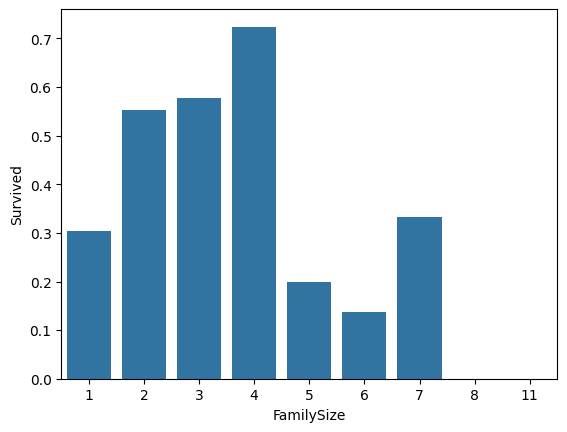

In [8]:
df_temp = df_train.copy()

df_temp = (
    df_temp
    .assign(
        FamilySize=lambda x: x['SibSp'] + x['Parch'] + 1
    )
    .groupby('FamilySize', as_index=False)
    .agg({'Survived': 'mean'})
)

sns.barplot(data=df_temp, x='FamilySize', y='Survived')

We can see that there is an apparent distinction comes from family size 1, 
family size 2-4, and family size > 5. Based on this distinction, I would create 
a binned property that divides this into three parts: small (family size 1), 
medium (family size 2-4), and large (family size > 5). This is also because
binned properties are better used when utilizing linear-typed models. Since
I'm using LinearSVC, in theory it would fit perfectly.

In [9]:
bins = [0, 1, 4, np.inf]
labels = ['small', 'medium', 'large']

df_temp['FamilyBin'] = pd.cut(df_temp['FamilySize'], bins=bins, labels=labels)

df_temp

,FamilySize,Survived,FamilyBin
0,1,0.303538,small
1,2,0.552795,medium
2,3,0.578431,medium
3,4,0.724138,medium
4,5,0.200000,large
5,6,0.136364,large
6,7,0.333333,large
7,8,0.000000,large
8,11,0.000000,large


<Axes: xlabel='FamilyBin', ylabel='Survived'>

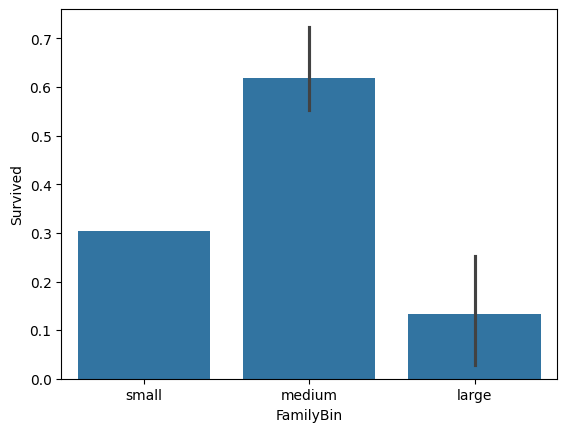

In [10]:
sns.barplot(data=df_temp, x='FamilyBin', y='Survived')

I have created a separate function called `FamilyBinFeatureExtractor`. Let's try it:

In [11]:
df_temp = df_train.copy()
family_binner = trf.FamilyBinExtractor()
df_temp = family_binner.fit_transform(df_temp)

display(df_temp)

,FamilyBin
0,Small
1,Small
2,Large
3,Large
4,Large
...,...
886,Large
887,Large
888,Large
889,Large


In [12]:
skim_data(df_test)

Total duplicate rows: 0
DF shape: (418, 11)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,418,100.00,"[892, 893, 894, 895, 896]"
1,Pclass,int64,0.000,0.0,0.0,3,0.72,"[3, 2, 1]"
2,Name,object,0.000,-,-,418,100.00,"[Kelly, Mr. James, Wilkes, Mrs. James (Ellen N..."
3,Sex,object,0.000,-,-,2,0.48,"[male, female]"
4,Age,float64,20.574,0.0,0.0,79,18.90,"[34.5, 47.0, 62.0, 27.0, 22.0]"
5,SibSp,int64,0.000,0.0,67.703,7,1.67,"[0, 1, 2, 3, 4]"
6,Parch,int64,0.000,0.0,77.512,8,1.91,"[0, 1, 3, 2, 4]"
7,Ticket,object,0.000,-,-,363,86.84,"[330911, 363272, 240276, 315154, 3101298]"
8,Fare,float64,0.239,0.0,0.478,169,40.43,"[7.8292, 7.0, 9.6875, 8.6625, 12.2875]"
9,Cabin,object,78.230,-,-,76,18.18,"[B45, E31, B57 B59 B63 B66, B36, A21]"


In [13]:
skim_data(df_train)

Total duplicate rows: 0
DF shape: (891, 12)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,891,100.00,"[1, 2, 3, 4, 5]"
1,Survived,int64,0.000,0.0,61.616,2,0.22,"[0, 1]"
2,Pclass,int64,0.000,0.0,0.0,3,0.34,"[3, 1, 2]"
3,Name,object,0.000,-,-,891,100.00,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,0.000,-,-,2,0.22,"[male, female]"
5,Age,float64,19.865,0.0,0.0,88,9.88,"[22.0, 38.0, 26.0, 35.0, 54.0]"
6,SibSp,int64,0.000,0.0,68.238,7,0.79,"[1, 0, 3, 4, 2]"
7,Parch,int64,0.000,0.0,76.094,7,0.79,"[0, 1, 2, 5, 3]"
8,Ticket,object,0.000,-,-,681,76.43,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,0.000,0.0,1.684,248,27.83,"[7.25, 71.2833, 7.925, 53.1, 8.05]"


<Axes: xlabel='Pclass', ylabel='count'>

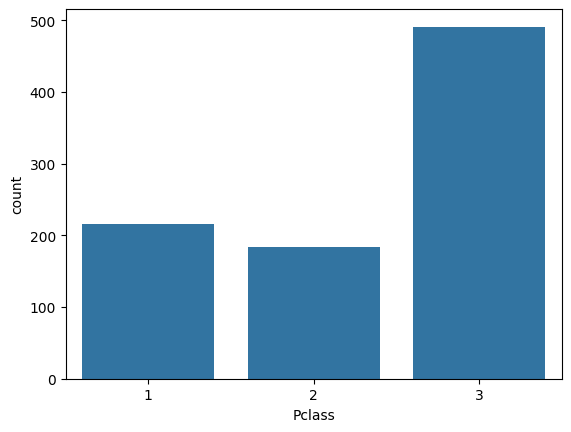

In [14]:
sns.countplot(data=df_train, x='Pclass')

<Axes: xlabel='Pclass', ylabel='Count'>

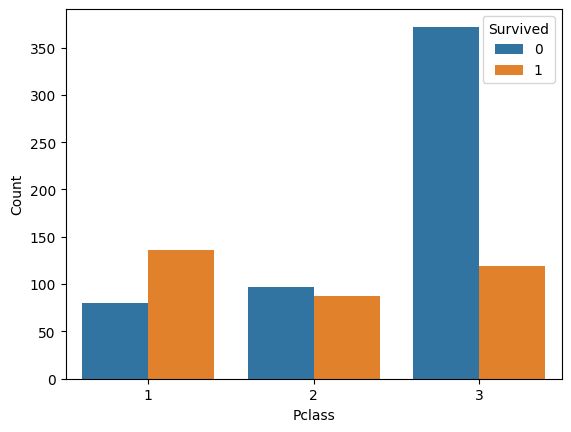

In [15]:
crosstab_result = pd.crosstab(df_train['Pclass'], df_train['Survived'])
stacked_data = crosstab_result.stack().reset_index().rename(columns={0:'Count'})
sns.barplot(data=stacked_data, x='Pclass', y='Count', hue='Survived')

In [16]:
def _clean_title(title):
    if title in ['Ms', 'Mlle']: return 'Miss'
    if title in ['Mme']: return 'Mrs'
    return title

X_fit = df_train.copy()
titles = (
    X_fit['Name']
    .str.extract(r' ([A-Za-z]+)\.', expand=False)
    .apply(_clean_title)
)

counts = titles.value_counts()
threshold = counts.get('Master', 0)
rare_titles = counts[counts < threshold].index.tolist()
X_fit['Title'] = titles.replace(rare_titles, 'Rare')
display(X_fit['Title'])
title_median_map_ = X_fit.groupby('Title')['Age'].median().to_dict()
global_median_ = X['Age'].median()
display(title_median_map_)
display(global_median_)

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886    Rare
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

{'Master': 3.5, 'Miss': 21.0, 'Mr': 30.0, 'Mrs': 35.0, 'Rare': 48.5}

np.float64(28.0)

In [17]:
df_train['Age'].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [18]:
import src.transformers as trf

imputer = trf.TitleBasedAgeImputer()
X_temp = imputer.fit_transform(X_train)
display(X_temp)

,Age,Title
541,9.0,Miss
306,22.0,Miss
454,30.0,Mr
199,24.0,Miss
397,46.0,Mr
...,...,...
51,21.0,Mr
590,35.0,Mr
41,27.0,Mrs
23,28.0,Mr


In [ ]:
from sklearn.compose import ColumnTransformer

import src.transformers as trf

preproccesor = ColumnTransformer(
    transformers=[
        ('family_binner', trf.FamilyBinExtractor(), ['SibSp', 'Parch']),
        ('cabin_indicator', trf.CabinExtractor(), ['Cabin']),
        ('title_age_imputer', trf.TitleBasedAgeImputer(), ['Name', 'Age']),
        ('fare_imputer', trf.FareImputer(), ['Fare']),
        ('embarked_imputer', trf.EmbarkedImputer(), ['Embarked']),
    ],
    remainder='passthrough'
)

X_temp = preproccesor.fit_transform(X_train)
feature_names = preproccesor.get_feature_names_out()
X_temp = pd.DataFrame(X_temp, columns=feature_names, index=X_train.index)
X_temp


,family_binner__FamilyBin,cabin_indicator__HasCabin,title_age_imputer__Age,title_age_imputer__Title,fare_imputer__Fare,embarked_imputer__Embarked,remainder__PassengerId,remainder__Pclass,remainder__Sex,remainder__Ticket
541,Large,0,9.0,Miss,31.275,S,542,3,female,347082
306,Single,0,22.0,Miss,110.8833,C,307,1,female,17421
454,Single,0,30.0,Mr,8.05,S,455,3,male,A/5 2817
199,Single,0,24.0,Miss,13.0,S,200,2,female,248747
397,Single,0,46.0,Mr,26.0,S,398,2,male,28403
...,...,...,...,...,...,...,...,...,...,...
51,Single,0,21.0,Mr,7.8,S,52,3,male,A/4. 39886
590,Single,0,35.0,Mr,7.125,S,591,3,male,STON/O 2. 3101273
41,Small,0,27.0,Mrs,21.0,S,42,2,female,11668
23,Single,1,28.0,Mr,35.5,S,24,1,male,113788


In [21]:
cat_columns = ['FamilyBin', 'Title', 'Embarked', 'Pclass', 'Sex']
num_columns = ['Age', 'Fare']
has_cabin_col = ['HasCabin']

### Create Full Pipeline

In [ ]:
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC

sklearn.set_config(transform_output="pandas") 

feature_engineering_processor = ColumnTransformer(
    transformers=[
        ('family_bin_extractor', trf.FamilyBinExtractor(), ['SibSp', 'Parch']),
        ('cabin_extractor', trf.CabinExtractor(), ['Cabin']),
        ('title_age_imputer', trf.TitleBasedAgeImputer(), ['Name', 'Age']),
        ('fare_imputer', trf.FareImputer(), ['Fare']),
        ('embarked_imputer', trf.EmbarkedImputer(), ['Embarked']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), num_columns),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_columns),
        ('has_cabin', 'passthrough', has_cabin_col)
    ],
    verbose_feature_names_out=False
)
full_pipeline = Pipeline(
    steps=[
        ('feature_engineering', feature_engineering_processor),
        ('preprocessing', preprocessor),
        ('classifier', LinearSVC(random_state=23))
    ]
)

### Cross-Validation & Hyperparameter Settings

Defining the parameter settings:

In [43]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

skf_splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=23)

param_grid = [
    {
        'classifier__penalty': ['l2'],
        'classifier__loss': ['squared_hinge'],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__max_iter': [10000]
    },
    {
        'classifier__penalty': ['l2'],
        'classifier__loss': ['hinge'],
        'classifier__dual': [True],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__max_iter': [10000]
    },
    {
        'classifier__penalty': ['l1'],
        'classifier__loss': ['squared_hinge'],
        'classifier__dual': [False],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__max_iter': [10000]
    }
]

Defining grid search:

In [44]:
grid_search = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    cv=skf_splitter,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

In [45]:
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)
print("Grid Search Complete.")

print("\n--- Best Results ---")
print(f"Best cross-validated score (Accuracy): {grid_search.best_score_:.4f}")
print("Best Hyperparameters:")
print(grid_search.best_params_)

Starting Grid Search...
Fitting 10 folds for each of 12 candidates, totalling 120 fits


/Users/bening/Courses/Pacmann.io/Portfolios/titanic-challenge/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Grid Search Complete.

--- Best Results ---
Best cross-validated score (Accuracy): 0.8314
Best Hyperparameters:
{'classifier__C': 1, 'classifier__dual': False, 'classifier__loss': 'squared_hinge', 'classifier__max_iter': 10000, 'classifier__penalty': 'l1'}


/Users/bening/Courses/Pacmann.io/Portfolios/titanic-challenge/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Test against `X_test`

In [47]:
from sklearn.metrics import accuracy_score, classification_report

final_predictions_on_test = grid_search.predict(X_test)

final_accuracy = accuracy_score(y_test, final_predictions_on_test)
print(f"Final Accuracy on the test set: {final_accuracy:.4f}")

print("\n--- Classification Report on Test Set ---")
print(classification_report(y_test, final_predictions_on_test))

Final Accuracy on the test set: 0.8324

--- Classification Report on Test Set ---
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       110
           1       0.84      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



### Test against `df_test`

In [48]:
import time

submission_predictions = grid_search.predict(df_test)

submission_df = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': submission_predictions
})

filename = f'input/submission_{time.time()}.csv'
submission_df.to_csv(filename, index=False)

print(f"\nSubmission file '{filename}' created successfully!")



Submission file 'input/submission_1759241863.508.csv' created successfully!
